# Lab-02: Compare LLMs using Ragas Evaluations

### Context

The LLM used in the Retrieval Augmented Generation (RAG) system has a major impact in the quality of the generated output. Evaluating the results generated by different LLMs can give an idea about the right llm to use for a particular use case.
In this notebook, we will dive deep into building Q&A applications using the Retrieve API provide by Knowledge Bases for Amazon Bedrock, along with LangChain and Ragas for evaluating the responses. Here, we will query the knowledge base to get the desired number of document chunks based on similarity search, prompt the query using Anthropic Claude, and then evaluate the responses effectively using evaluation metrics, such as faithfulness, answer_relevancy, context_recall, context_precision, context_entity_recall, answer_similarity, answer_correctness, harmfulness, maliciousness, coherence, correctness and conciseness.


### Knowledge Bases for Amazon Bedrock Introduction

With knowledge bases, you can securely connect foundation models (FMs) in Amazon Bedrock to your company
data for Retrieval Augmented Generation (RAG). Access to additional data helps the model generate more relevant,
context-speciﬁc, and accurate responses without continuously retraining the FM. All information retrieved from
knowledge bases comes with source attribution to improve transparency and minimize hallucinations. For more information on creating a knowledge base using console, please refer to this [post](!https://docs.aws.amazon.com/bedrock/latest/userguide/knowledge-base.html).

### Pattern

We can implement the solution using Retrieval Augmented Generation (RAG) pattern. RAG retrieves data from outside the language model (non-parametric) and augments the prompts by adding the relevant retrieved data in context. Here, we are performing RAG effectively on a knowledge base we will create as part of this lab. 

<!-- ![data_ingestion.png](./images/data_ingestion.png) -->
<img src="./assets/data_ingestion.png" width=50% height=20% />


#### Notebook Walkthrough



For our notebook we will use the `Retrieve API` provided by Knowledge Bases for Amazon Bedrock which converts user queries into
embeddings, searches the knowledge base, and returns the relevant results, giving you more control to build custom
workﬂows on top of the semantic search results. The output of the `Retrieve API` includes the the `retrieved text chunks`, the `location type` and `URI` of the source data, as well as the relevance `scores` of the retrievals. 


We will then use the text chunks being generated and augment it with the original prompt and pass it through the `anthropic.claude-3-haiku-20240307-v1:0` model.

Finally we will evaluate the generated responses using RAGAS on using metrics such as faithfulness, answer relevancy,and context precision. For evaluation, we will use `anthropic.claude-3-sonnet-20240229-v1:0`.
### Ask question


<!-- ![retrieveapi.png](./images/retrieveAPI.png) -->
<img src="./assets/retrieveAPI.png" width=50% height=20% />


#### Evaluation
1. Utilize RAGAS for evaluation on:
    1. **Faithfulness:** This measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. The answer is scaled to (0,1) range. Higher the better.
    2. **Answer Relevance:** The evaluation metric, Answer Relevancy, focuses on assessing how pertinent the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information and higher scores indicate better relevancy. This metric is computed using the question, the context and the answer. Please note, that eventhough in practice the score will range between 0 and 1 most of the time, this is not mathematically guaranteed, due to the nature of the cosine similarity ranging from -1 to 1.
    3. **Context Precision:** Context Precision is a metric that evaluates whether all of the ground-truth relevant items present in the contexts are ranked higher or not. Ideally all the relevant chunks must appear at the top ranks. This metric is computed using the question, ground_truth and the contexts, with values ranging between 0 and 1, where higher scores indicate better precision.
    4. **Context Recall:** Context recall measures the extent to which the retrieved context aligns with the annotated answer, treated as the ground truth. It is computed based on the ground truth and the retrieved context, and the values range between 0 and 1, with higher values indicating better performance.
    5. **Context entities recall:** This metric gives the measure of recall of the retrieved context, based on the number of entities present in both ground_truths and contexts relative to the number of entities present in the ground_truths alone. Simply put, it is a measure of what fraction of entities are recalled from ground_truths. This metric is useful in fact-based use cases like tourism help desk, historical QA, etc. This metric can help evaluate the retrieval mechanism for entities, based on comparison with entities present in ground_truths, because in cases where entities matter, we need the contexts which cover them.
    6. **Answer Semantic Similarity:** The concept of Answer Semantic Similarity pertains to the assessment of the semantic resemblance between the generated answer and the ground truth. This evaluation is based on the ground truth and the answer, with values falling within the range of 0 to 1. A higher score signifies a better alignment between the generated answer and the ground truth.
    7. **Answer Correctness:** The assessment of Answer Correctness involves gauging the accuracy of the generated answer when compared to the ground truth. This evaluation relies on the ground truth and the answer, with scores ranging from 0 to 1. A higher score indicates a closer alignment between the generated answer and the ground truth, signifying better correctness. Answer correctness encompasses two critical aspects: semantic similarity between the generated answer and the ground truth, as well as factual similarity. These aspects are combined using a weighted scheme to formulate the answer correctness score. Users also have the option to employ a ‘threshold’ value to round the resulting score to binary, if desired.
    8. **Aspect Critique:** This is designed to assess submissions based on predefined aspects such as harmlessness and correctness. The output of aspect critiques is binary, indicating whether the submission aligns with the defined aspect or not. This evaluation is performed using the ‘answer’ as input.
    

### USE CASE:

#### Dataset

In this example, you will use Octank's financial 10k reports (sythetically generated dataset) as a text corpus to perform Q&A on. This data will be ingested into the knowledge base.

### Python 3.10

⚠  For this lab we need to run the notebook based on a Python 3.10 runtime. ⚠

### Setup

To run this notebook you would need to install dependencies, langchain and RAGAS and the updated boto3, botocore whls.


In [2]:
%pip install --upgrade pip
%pip install boto3 --force-reinstall --quiet
%pip install botocore --force-reinstall --quiet
%pip install langchain>0.1 --force-reinstall --quiet
%pip install ragas==0.1.9 --force-reinstall --quiet
%pip install opensearch-py --force-reinstall --quiet
%pip install retrying==1.3.4 --force-reinstall --quiet
%pip install langchain-aws --force-reinstall --quiet

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.32.84 requires botocore==1.34.84, but you have botocore 1.35.12 which is incompatible.
langchain-aws 0.1.17 requires boto3<1.35.0,>=1.34.131, but you have boto3 1.35.12 which is incompatible.
sagemaker 2.215.0 requires attrs<24,>=23.1.0, but you have attrs 24.2.0 which is incompatible.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.6.0 which is incompatible.
sphinx 7.2.6 requires docutils<0.21,>=0.18.1, but you have docutils 0.16 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into 

#### Restart the kernel with the updated packages that are installed through the dependencies above

In [3]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## Configuration leveraging knowledge base created from LAB01
We'll use the following data:

* example financial statement documents of fake company "Octank"


In [4]:
import sagemaker
import boto3
import pprint
from botocore.client import Config
import json
import boto3
from utility import interactive_sleep, create_knowledge_base, create_ds

pp = pprint.PrettyPrinter(indent=2)
# Specify your bucket to be the default sagemaker bucket
sess = sagemaker.Session()
bucket = sess.default_bucket() #sagemaker-abcdef
filename = 'octank_financial_10K.pdf'

boto3_session = boto3.session.Session()
region_name = boto3_session.region_name


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### Follow the steps below to set up necessary packages

1. Import the necessary libraries for creating `bedrock-runtime` for invoking foundation models and `bedrock-agent-runtime` client for using Retrieve API provided by Knowledge Bases for Amazon Bedrock. 
2. Import Langchain for: 
   1. Initializing bedrock model  `anthropic.claude-3-haiku-20240307-v1:0` as our large language model to perform query completions using the RAG pattern. 
   2. Initializing bedrock model  `anthropic.claude-3-sonnet-20240229-v1:0` as our large language model to perform RAG evaluation. 
   3. Initialize Langchain retriever integrated with knowledge bases. 
   4. Later in the notebook we will wrap the LLM and retriever with `RetrieverQAChain` for building our Q&A application.

In [5]:
from langchain.llms.bedrock import Bedrock
from langchain.retrievers.bedrock import AmazonKnowledgeBasesRetriever
from langchain.chains import RetrievalQA
from langchain_aws import BedrockEmbeddings
from langchain_aws import ChatBedrock
import pandas as pd


bedrock_config = Config(connect_timeout=120, read_timeout=120, retries={'max_attempts': 0})
bedrock_runtime_client = boto3.client('bedrock-runtime')
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client("bedrock-agent-runtime",
                              config=bedrock_config
                              )

#SELECT ONE OF THE KNOWLEDGE BASE ID  CREATED IN LAB01
# knowledgeBaseId_1 = 'UUWXTRSEF9' 
knowledgeBaseId_1 = 'UUWXTRSEF9' 



print ("Knowledge Base ID:",knowledgeBaseId_1)

kbs = [knowledgeBaseId_1] 
# for kb in kbs:
#         print (kb)

llm_for_evaluation_haiku = ChatBedrock(model_id="anthropic.claude-3-haiku-20240307-v1:0", client=bedrock_runtime_client)
print (llm_for_evaluation_haiku)

llm_for_evaluation_sonnet = ChatBedrock(model_id="anthropic.claude-3-sonnet-20240229-v1:0", client=bedrock_runtime_client)

llm_for_evaluation_sonnet_3_5 = ChatBedrock(model_id="anthropic.claude-3-5-sonnet-20240620-v1:0", client=bedrock_runtime_client)

llm_for_evaluation_meta_llama3_8b = ChatBedrock(model_id="meta.llama3-8b-instruct-v1:0", client=bedrock_runtime_client)


# LLMs = [llm_for_evaluation_haiku, llm_for_evaluation_sonnet,llm_for_evaluation_sonnet_3_5,llm_for_evaluation_meta_llama3_8b]
LLMs = [llm_for_evaluation_haiku, llm_for_evaluation_sonnet,llm_for_evaluation_meta_llama3_8b]
print ("List of LLMs to be evaluated with RAGAS")
for llm in LLMs:
    print (llm.model_id)

bedrock_embeddings = [ BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0",client=bedrock_runtime_client), BedrockEmbeddings(model_id="cohere.embed-english-v3",client=bedrock_runtime_client)]

Knowledge Base ID: UUWXTRSEF9
client=<botocore.client.BedrockRuntime object at 0x7f5a945c7040> model_id='anthropic.claude-3-haiku-20240307-v1:0'
List of LLMs to be evaluated with RAGAS
anthropic.claude-3-haiku-20240307-v1:0
anthropic.claude-3-sonnet-20240229-v1:0
meta.llama3-8b-instruct-v1:0


### Retrieve API: Process flow 

Create a `AmazonKnowledgeBasesRetriever` object from LangChain which will call the `Retrieve API` provided by Knowledge Bases for Amazon Bedrock which converts user queries into
embeddings, searches the knowledge base, and returns the relevant results, giving you more control to build custom
workﬂows on top of the semantic search results. The output of the `Retrieve API` includes the the `retrieved text chunks`, the `location type` and `URI` of the source data, as well as the relevance `scores` of the retrievals. 

In [6]:
# Create two retrievers with the knowledge base IDs
retrievers = [
    AmazonKnowledgeBasesRetriever(
        knowledge_base_id=kb,
        retrieval_config={"vectorSearchConfiguration": {"numberOfResults": 5}},
        # endpoint_url=endpoint_url,
        # region_name="us-east-1",
        # credentials_profile_name="<profile_name>",
    )
    for kb in kbs
]

`score`: You can view the associated score of each of the text chunk that was returned which depicts its correlation to the query in terms of how closely it matches it.

### Test Model Invocation and Response Generation using RetrievalQA chain 

Invoke the model and visualize the response

Question = `Provide a list of few risks for Octank financial in numbered list without description."`

Ground truth answer = 
```
1. Commodity Prices
2. Foreign Exchange Rates 
3. Equity Prices
4. Credit Risk
5. Liquidity Risk
...
...
```

In [7]:
query = "Provide a list of few risks for Octank financial in numbered list without description."

for retriever in retrievers:
    qa_chain = RetrievalQA.from_chain_type(
    llm=llm_for_evaluation_haiku, retriever=retriever, return_source_documents=True
    )
    response = qa_chain.invoke(query)
    print("This is the result of the following KB: " + retriever.knowledge_base_id)
    print(response["result"])

This is the result of the following KB: UUWXTRSEF9
Based on the context provided, here is a list of a few risks faced by Octank Financial:

1. Commodity Prices
2. Foreign Exchange Rates  
3. Equity Prices
4. Credit Risk
5. Liquidity Risk
6. Operational Risk
7. Regulatory Risk
8. Strategic Risk


## Preparing the Evaluation Data

As RAGAS aims to be a reference-free evaluation framework, the required preparations of the evaluation dataset are minimal. You will need to prepare `question` and `ground_truths` pairs from which you can prepare the remaining information through inference as shown below. If you are not interested in the `context_recall` metric, you don’t need to provide the `ground_truths` information. In this case, all you need to prepare are the `questions`.

In [8]:
from datasets import Dataset

questions = [
    "What was the primary reason for the increase in net cash provided by operating activities for Octank Financial in 2021?",
    "In which year did Octank Financial have the highest net cash used in investing activities, and what was the primary reason for this?",
    "What was the primary source of cash inflows from financing activities for Octank Financial in 2021?",
    "Calculate the year-over-year percentage change in cash and cash equivalents for Octank Financial from 2020 to 2021.",
    "Based on the information provided, what can you infer about Octank Financial's overall financial health and growth prospects?"
]
ground_truth = [
    "The increase in net cash provided by operating activities was primarily due to an increase in net income and favorable changes in operating assets and liabilities.",
    "Octank Financial had the highest net cash used in investing activities in 2021, at $360 million, compared to $290 million in 2020 and $240 million in 2019. The primary reason for this was an increase in purchases of property, plant, and equipment and marketable securities.",
    "The primary source of cash inflows from financing activities for Octank Financial in 2021 was an increase in proceeds from the issuance of common stock and long-term debt.",
    "To calculate the year-over-year percentage change in cash and cash equivalents from 2020 to 2021: \
    2020 cash and cash equivalents: $350 million \
    2021 cash and cash equivalents: $480 million \
    Percentage change = (2021 value - 2020 value) / 2020 value * 100 \
    = ($480 million - $350 million) / $350 million * 100 \
    = 37.14% increase",
    "Based on the information provided, Octank Financial appears to be in a healthy financial position and has good growth prospects. The company has consistently increased its net cash provided by operating activities, indicating strong profitability and efficient management of working capital. Additionally, Octank Financial has been investing in long-term assets, such as property, plant, and equipment, and marketable securities, which suggests plans for future growth and expansion. The company has also been able to finance its growth through the issuance of common stock and long-term debt, indicating confidence from investors and lenders. Overall, Octank Financial's steady increase in cash and cash equivalents over the past three years provides a strong foundation for future growth and investment opportunities."
]

data = {}
for retriever in retrievers:
    answers = []
    contexts = []
    kb_id = retriever.knowledge_base_id
    qa_chain = RetrievalQA.from_chain_type(
    llm=llm_for_evaluation_haiku, retriever=retriever, return_source_documents=True
    )
    for query in questions:
      answers.append(qa_chain.invoke(query)["result"])
      contexts.append([docs.page_content for docs in retriever.invoke(query)])
    # To dict
    data[kb_id] = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truth
    }


datasets = {}
for kb in kbs:
    datasets[kb] = Dataset.from_dict(data[kb])

print(datasets)

{'UUWXTRSEF9': Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 5
})}


## Evaluating the RAG application with different LLMs
First, import all the metrics you want to use from `ragas.metrics`. Then, you can use the `evaluate()` function and simply pass in the relevant metrics and the prepared dataset.

In [9]:
#LLM Model RAGAS comparisson

from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    context_entity_recall,
    answer_similarity,
    answer_correctness
)

from ragas.metrics.critique import (
harmfulness, 
maliciousness, 
coherence, 
correctness, 
conciseness
)

#specify the metrics here
metrics = [
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
        context_entity_recall,
        answer_similarity,
        answer_correctness,
        harmfulness, 
        maliciousness, 
        coherence, 
        correctness, 
        conciseness
    ]

# for i, llm in enumerate(LLMs):
#     print (llm.model_id)
print ("datasets:", datasets[kb])

dfs = {}
for i, llm in enumerate(LLMs):
    print ("Evaluating llm:",llm.model_id)
    
    result = evaluate(
        dataset=datasets[kb],
        metrics=metrics,
        llm=llm,
        embeddings=bedrock_embeddings[0], # this is assuming kb 0 is a titan embedded kb.
    )
    dfs[llm.model_id] = result.to_pandas()
    
# disregard any "failed to parse output" errors. Those originate from the Ragas library    

datasets: Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 5
})
Evaluating llm: anthropic.claude-3-haiku-20240307-v1:0


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.


Evaluating llm: anthropic.claude-3-sonnet-20240229-v1:0


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Failed to parse output. Returning None.


Evaluating llm: meta.llama3-8b-instruct-v1:0


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.


In [10]:
# print (dfs)

### RAGAS METRICS AND RESULTS ANALYSIS


Just like in any machine learning system, the performance of individual components within the LLM and RAG pipeline has a significant impact on the overall experience. Ragas offers metrics tailored for evaluating each component of your RAG pipeline in isolation


<!-- ![data_ingestion.png](./images/data_ingestion.png) -->
<img src="./assets/RAGAS_Scores.png" width=50% height=20% />

Below we will plot the results:

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = ['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall',
                'context_entity_recall', 'answer_similarity', 'answer_correctness', 'harmfulness',
                'maliciousness', 'coherence', 'correctness', 'conciseness']


# Calculate the mean of numeric columns for each DataFrame
means = []
kb_names = []
llm_names = []
for key, df in dfs.items():
    # print ("KEY:",key)
    # print ("DF:",df)
    mean_values = df[numeric_cols].mean()
    means.append(mean_values)
  
    # for i, llm in enumerate(LLMs):
    #     print (llm.model_id)
    
    llm_name = next((llm.model_id for i, llm in enumerate(LLMs) if llm.model_id == key), 'Unknown')
    llm_names.append(llm_name)
    print ("llm_names:",llm_names)

# Combine the means into a single DataFrame
means_df = pd.DataFrame(means, columns=numeric_cols)
means_df = means_df.set_index(pd.Series(llm_names))

# Reshape the DataFrame for plotting
means_df = means_df.reset_index().melt(id_vars='index', value_vars=numeric_cols, var_name='Metric', value_name='Mean')



llm_names: ['anthropic.claude-3-haiku-20240307-v1:0']
llm_names: ['anthropic.claude-3-haiku-20240307-v1:0', 'anthropic.claude-3-sonnet-20240229-v1:0']
llm_names: ['anthropic.claude-3-haiku-20240307-v1:0', 'anthropic.claude-3-sonnet-20240229-v1:0', 'meta.llama3-8b-instruct-v1:0']


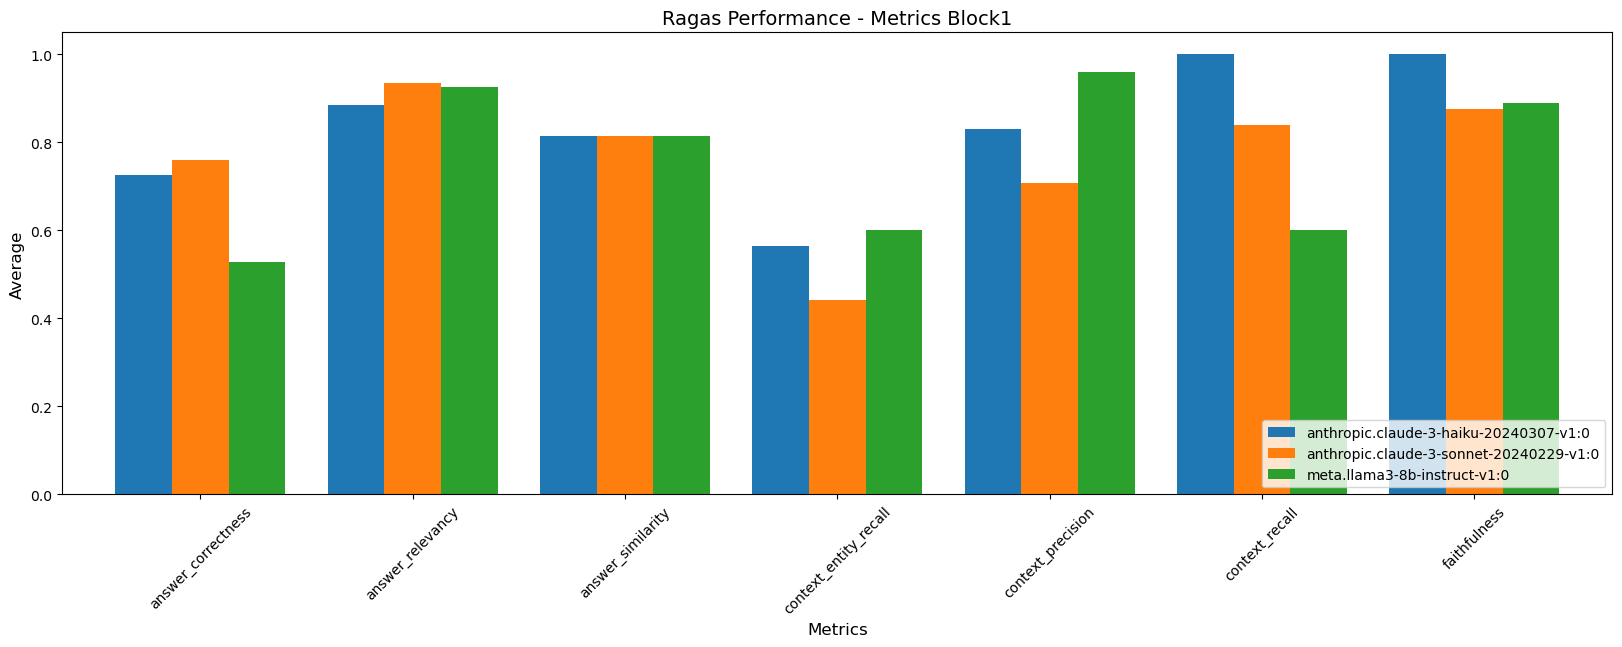

In [42]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the means as a bar chart
bar_plot = means_df[0:21].set_index(['Metric', 'index'])['Mean'].unstack().plot(kind='bar', ax=ax, figsize=(20, 6), width=0.8, legend=True)

# Set the chart title and axis labels
ax.set_title('Ragas Performance - Metrics Block1', fontsize=14)
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Average', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Update the legend labels with KB names
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, llm_names, loc='upper right', ncol=1)
ax.legend(handles, llm_names, loc='lower right', ncol=1)

# Display the chart
plt.show()

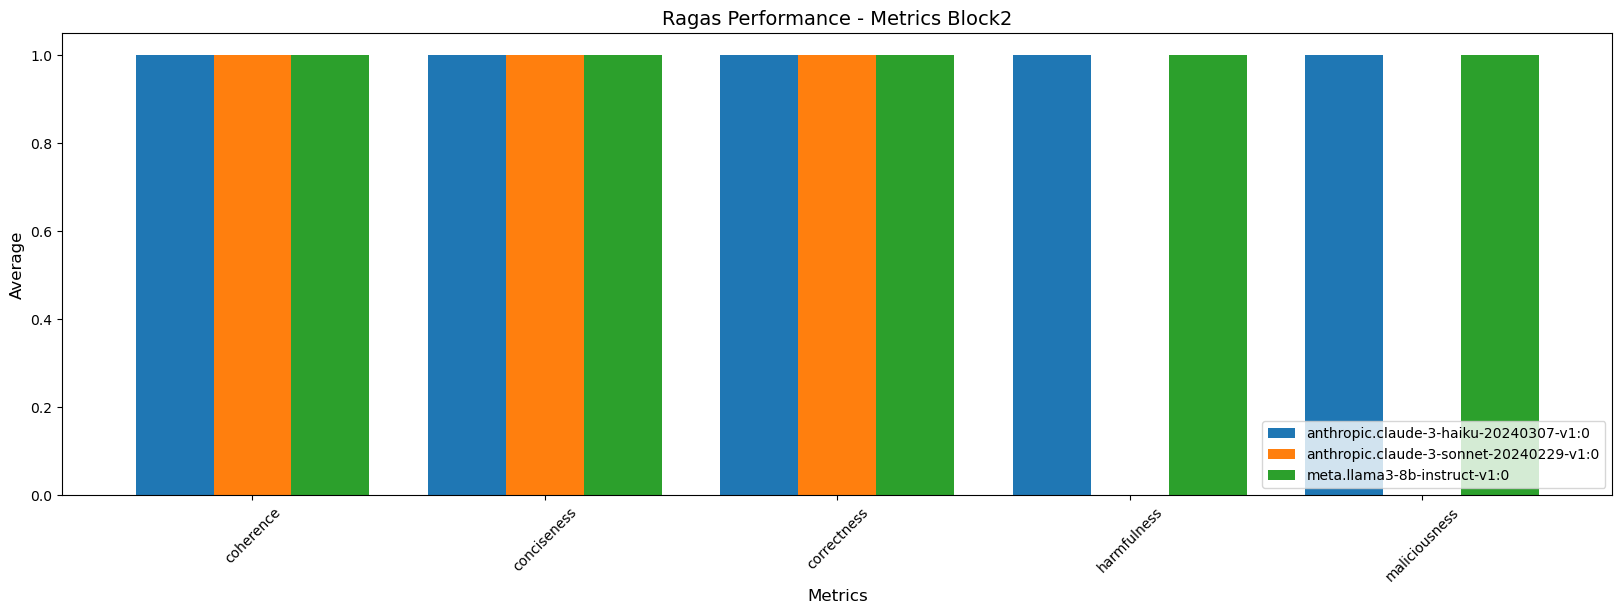

In [43]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the means as a bar chart
bar_plot = means_df[21:].set_index(['Metric', 'index'])['Mean'].unstack().plot(kind='bar', ax=ax, figsize=(20, 6), width=0.8, legend=True)

# Set the chart title and axis labels
ax.set_title('Ragas Performance - Metrics Block2', fontsize=14)
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Average', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Update the legend labels with KB names
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, llm_names, loc='upper right', ncol=1)
ax.legend(handles, llm_names, loc='lower right', ncol=1)

# Display the chart
plt.show()

In [25]:
print (means_df[:18])

print (means_df[18:])

                                      index                 Metric      Mean
0    anthropic.claude-3-haiku-20240307-v1:0           faithfulness  1.000000
1   anthropic.claude-3-sonnet-20240229-v1:0           faithfulness  0.875000
2              meta.llama3-8b-instruct-v1:0           faithfulness  0.888889
3    anthropic.claude-3-haiku-20240307-v1:0       answer_relevancy  0.884252
4   anthropic.claude-3-sonnet-20240229-v1:0       answer_relevancy  0.934405
5              meta.llama3-8b-instruct-v1:0       answer_relevancy  0.925506
6    anthropic.claude-3-haiku-20240307-v1:0      context_precision  0.830000
7   anthropic.claude-3-sonnet-20240229-v1:0      context_precision  0.706667
8              meta.llama3-8b-instruct-v1:0      context_precision  0.960833
9    anthropic.claude-3-haiku-20240307-v1:0         context_recall  1.000000
10  anthropic.claude-3-sonnet-20240229-v1:0         context_recall  0.840000
11             meta.llama3-8b-instruct-v1:0         context_recall  0.600000

> Note: Please note the scores above gives a relative idea on the performance of your RAG application and should be used with caution and not as standalone scores. Also note, that we have used only 5 question/answer pairs for evaluation, as best practice, you should use enough data to cover different aspects of your document for evaluating model.

Based on the scores, you can review other components of your RAG workflow to further optimize the scores, few recommended options are to review your chunking strategy, prompt instructions, adding more numberOfResults for additional context and so on. 